In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398780 sha256=acac122e5e261207de9246b07e5eed09c866367d937cdfb7089eb4a5e09e3c50
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [20]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from collections import namedtuple, deque

In [21]:
# ==========================================
# 0. 구글 드라이브 연결 (저장용)
# ==========================================
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/My Drive/DQN_Result"

# 폴더가 없으면 생성
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    print(f"📂 폴더 생성 완료: {SAVE_PATH}")
else:
    print(f"📂 저장 경로 확인: {SAVE_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 저장 경로 확인: /content/drive/My Drive/DQN_Result


In [22]:
# ==========================================
# 1. 설정 (Configuration)
# ==========================================
class Config:
    def __init__(self):
        self.ENV_NAME = "LunarLander-v3"  # 최신 v3 사용
        self.SEED = 42
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 하이퍼파라미터
        self.BUFFER_SIZE = int(1e5)
        self.BATCH_SIZE = 64
        self.GAMMA = 0.99
        self.TAU = 1e-3
        self.LR = 5e-4
        self.UPDATE_EVERY = 4

        self.EPS_START = 1.0
        self.EPS_END = 0.01
        self.EPS_DECAY = 0.995

config = Config()

In [23]:
# ==========================================
# 2. 모델 & 메모리 & 에이전트
# ==========================================
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(config.DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(config.DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(config.DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(config.DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(config.DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

class Agent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(config.DEVICE)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(config.DEVICE)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=config.LR)
        self.memory = ReplayBuffer(action_size, config.BUFFER_SIZE, config.BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % config.UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > config.BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, config.GAMMA)

    def act(self, state, eps=0.0):
        # 🟢 [수정됨] 오류 해결 핵심 부분: 반드시 정수(Action)를 리턴하도록 보장
        state = torch.from_numpy(state).float().unsqueeze(0).to(config.DEVICE)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-Greedy
        if random.random() > eps:
            return int(np.argmax(action_values.cpu().data.numpy())) # 정수로 변환하여 리턴
        else:
            return int(random.choice(np.arange(self.action_size))) # 정수로 변환하여 리턴

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        # Double DQN 로직
        indices = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, indices)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, config.TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [24]:
# ==========================================
# 3. 학습 루프 (Training Loop)
# ==========================================
def train_dqn(n_episodes=2000, max_t=1000):
    env = gym.make(config.ENV_NAME, render_mode=None)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = Agent(state_size, action_size, seed=config.SEED)

    scores = []
    scores_window = deque(maxlen=100)
    eps = config.EPS_START

    print(f"🚀 {config.ENV_NAME} 학습 시작! (Double DQN)")
    print("-" * 50)

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps) # 여기서 이제 None이 나오지 않습니다.

            # 오류 발생 지점 방지용 (혹시 모를 타입 체크)
            if action is None:
                action = env.action_space.sample()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done: break

        scores_window.append(score)
        scores.append(score)
        eps = max(config.EPS_END, eps * config.EPS_DECAY)

        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")

        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), os.path.join(SAVE_PATH, 'checkpoint.pth'))

        if np.mean(scores_window) >= 200.0:
            print(f'\n\n🎉 환경 해결! ({i_episode-100} 에피소드)')
            torch.save(agent.qnetwork_local.state_dict(), os.path.join(SAVE_PATH, 'final_model.pth'))
            break

    return scores

🚀 LunarLander-v3 학습 시작! (Double DQN)
--------------------------------------------------
Episode 100	Average Score: -166.89
Episode 200	Average Score: -90.92
Episode 300	Average Score: -40.33
Episode 400	Average Score: 22.48
Episode 500	Average Score: 56.70
Episode 600	Average Score: 126.02
Episode 700	Average Score: 179.69
Episode 760	Average Score: 201.40

🎉 환경 해결! (660 에피소드)


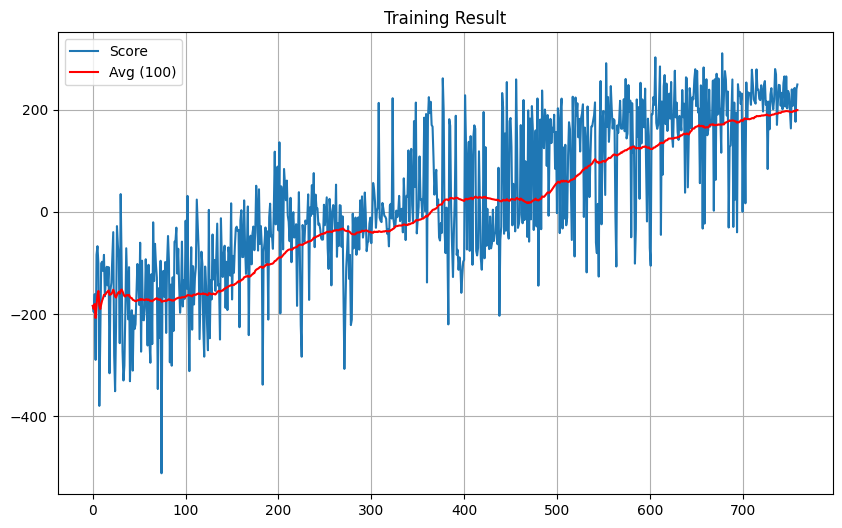

✅ 그래프 저장 완료


In [25]:
# ==========================================
# 실행
# ==========================================
if __name__ == "__main__":
    scores = train_dqn()

    # 그래프 저장
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label='Score')
    plt.plot([np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))], label='Avg (100)', color='red')
    plt.title('Training Result')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_PATH, 'result_graph.png'))
    plt.show()
    print("✅ 그래프 저장 완료")